In [1]:
import os
import pandas as pd
os.chdir('..')
from db_connection.connection import PostgresConnection
from src.utils import missing_values_table, convert_bytes_to_megabytes
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Connected to PostgreSQL database!
      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0  1823652.0  2.082014e+14   3.366496e+10  3.552121e+13   
1  1365104.0  2.082019e+14   3.368185e+10  3.579401e+13   
2  1361762.0  2.082003e+14   3.376063e+10  3.528151e+13   
3  1321509.0  2.082014e+14   3.375034e+10  3.535661e+13   
4  1089009.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...  Youtube DL (Bytes)  Youtube UL (Bytes)  \
0  9.16456699548519E+015  ...          15854611.0           2501332.0   
1                L77566A  ...         

In [2]:
db = PostgresConnection(dbname='postgres', user='postgres', password='ocho')
db.connect()

# Example query
query = "SELECT * FROM xdr_data"
result = db.execute_query(query)

# Convert the result to a Pandas DataFrame
df = pd.DataFrame(result, columns=[desc[0] for desc in db.cursor.description])
print(df.head())  # Display the first few rows of the DataFrame

# Close the connection when done
db.close_connection()

Connected to PostgreSQL database!
      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0  1823652.0  2.082014e+14   3.366496e+10  3.552121e+13   
1  1365104.0  2.082019e+14   3.368185e+10  3.579401e+13   
2  1361762.0  2.082003e+14   3.376063e+10  3.528151e+13   
3  1321509.0  2.082014e+14   3.375034e+10  3.535661e+13   
4  1089009.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...  Youtube DL (Bytes)  Youtube UL (Bytes)  \
0  9.16456699548519E+015  ...          15854611.0           2501332.0   
1                L77566A  ...         

In [3]:
#Aggregate information per customer
# Treat missing values by replacing with the mean or mode
df['Avg RTT DL (ms)'].fillna(df['Avg RTT DL (ms)'].mean(), inplace=True)
df['Avg RTT UL (ms)'].fillna(df['Avg RTT UL (ms)'].mean(), inplace=True)
df['Avg Bearer TP DL (kbps)'].fillna(df['Avg Bearer TP DL (kbps)'].mean(), inplace=True)
df['Avg Bearer TP UL (kbps)'].fillna(df['Avg Bearer TP UL (kbps)'].mean(), inplace=True)
df['Handset Type'].fillna(df['Handset Type'].mode()[0], inplace=True)

C:\Users\akili\AppData\Local\Temp\ipykernel_23524\210348983.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Avg RTT DL (ms)'].fillna(df['Avg RTT DL (ms)'].mean(), inplace=True)
C:\Users\akili\AppData\Local\Temp\ipykernel_23524\210348983.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

In [4]:
# Aggregate the required information per customer
aggregated_df = df.groupby('MSISDN/Number').agg({'Avg Bearer TP DL (kbps)': 'mean',
                                                 'Avg RTT DL (ms)': 'mean',
                                                 'Handset Type': 'first',
                                                 'TCP DL Retrans. Vol (Bytes)': 'mean'})

In [5]:
# Compute and list top, bottom, and most frequent values

# TCP values
top_10_tcp = df['TCP DL Retrans. Vol (Bytes)'].nlargest(10)
bottom_10_tcp = df['TCP DL Retrans. Vol (Bytes)'].nsmallest(10)
most_frequent_tcp = df['TCP DL Retrans. Vol (Bytes)'].value_counts().head(10)

In [6]:
# RTT values
top_10_rtt = df['Avg RTT DL (ms)'].nlargest(10)
bottom_10_rtt = df['Avg RTT DL (ms)'].nsmallest(10)
most_frequent_rtt = df['Avg RTT DL (ms)'].value_counts().head(10)

In [7]:
# Throughput values
top_10_throughput = df['Avg Bearer TP DL (kbps)'].nlargest(10)
bottom_10_throughput = df['Avg Bearer TP DL (kbps)'].nsmallest(10)
most_frequent_throughput = df['Avg Bearer TP DL (kbps)'].value_counts().head(10)

In [8]:
# Compute and report

# Distribution of average throughput per handset type
throughput_distribution = df.groupby('Handset Type')['Avg Bearer TP DL (kbps)'].mean()

# Average TCP retransmission view per handset type
tcp_retransmission_view = df.groupby('Handset Type')['TCP DL Retrans. Vol (Bytes)'].mean()

# Print the results
print(" Aggregated information per customer:")
print(aggregated_df)

print("\n Top, bottom, and most frequent values:")
print("Top 10 TCP values:")
print(top_10_tcp)
print("Bottom 10 TCP values:")
print(bottom_10_tcp)
print("Most frequent TCP values:")
print(most_frequent_tcp)

print("\nTop 10 RTT values:")
print(top_10_rtt)
print("Bottom 10 RTT values:")
print(bottom_10_rtt)
print("Most frequent RTT values:")
print(most_frequent_rtt)

print("\nTop 10 Throughput values:")
print(top_10_throughput)
print("Bottom 10 Throughput values:")
print(bottom_10_throughput)
print("Most frequent Throughput values:")
print(most_frequent_throughput)

print("\n Distribution of average throughput per handset type:")
print(throughput_distribution)

print("\n - Average TCP retransmission view per handset type:")
print(tcp_retransmission_view)

 Aggregated information per customer:
               Avg Bearer TP DL (kbps)  Avg RTT DL (ms)  \
MSISDN/Number                                             
3.360100e+10                      37.0        46.000000   
3.360100e+10                      48.0        30.000000   
3.360100e+10                      48.0       109.795706   
3.360101e+10                     204.0        69.000000   
3.360101e+10                   20197.5        57.000000   
...                                ...              ...   
3.379000e+10                    9978.0        42.000000   
3.379000e+10                      68.0        34.000000   
3.197021e+12                       1.0       109.795706   
3.370000e+14                      11.0       109.795706   
8.823971e+14                       2.0       109.795706   

                                   Handset Type  TCP DL Retrans. Vol (Bytes)  
MSISDN/Number                                                                 
3.360100e+10     Huawei P20 Lite Hua

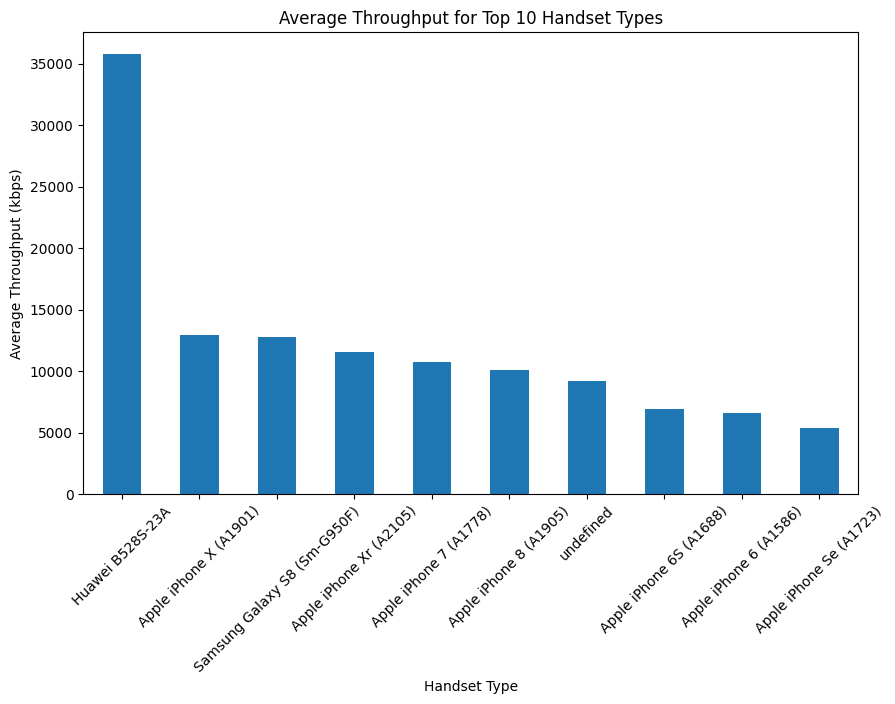

In [9]:
# Bar chart for average throughput per handset type
plt.figure(figsize=(10, 6))
top_10_handsets = df['Handset Type'].value_counts().head(10)
top_10_throughput = df[df['Handset Type'].isin(top_10_handsets.index)]
throughput_chart = top_10_throughput.groupby('Handset Type')['Avg Bearer TP DL (kbps)'].mean().sort_values(ascending=False)
throughput_chart.plot(kind='bar')
plt.title('Average Throughput for Top 10 Handset Types')
plt.xlabel('Handset Type')
plt.ylabel('Average Throughput (kbps)')
plt.xticks(rotation=45)
plt.show()